<a href="https://colab.research.google.com/github/ocaes/Water-Analysis-/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install xee -q

In [ ]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter


In [5]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

EEException: Caller does not have required permission to use project ee-saeiddalirisu. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=ee-saeiddalirisu and then retry. Propagation of the new permission may take a few minutes.

In [ ]:
map=geemap.Map(basemap="SATELLITE")
map

In [ ]:
start_time = '2024-01-01'
end_time = '2024-12-31'
roi = map.draw_last_feature.geometry()

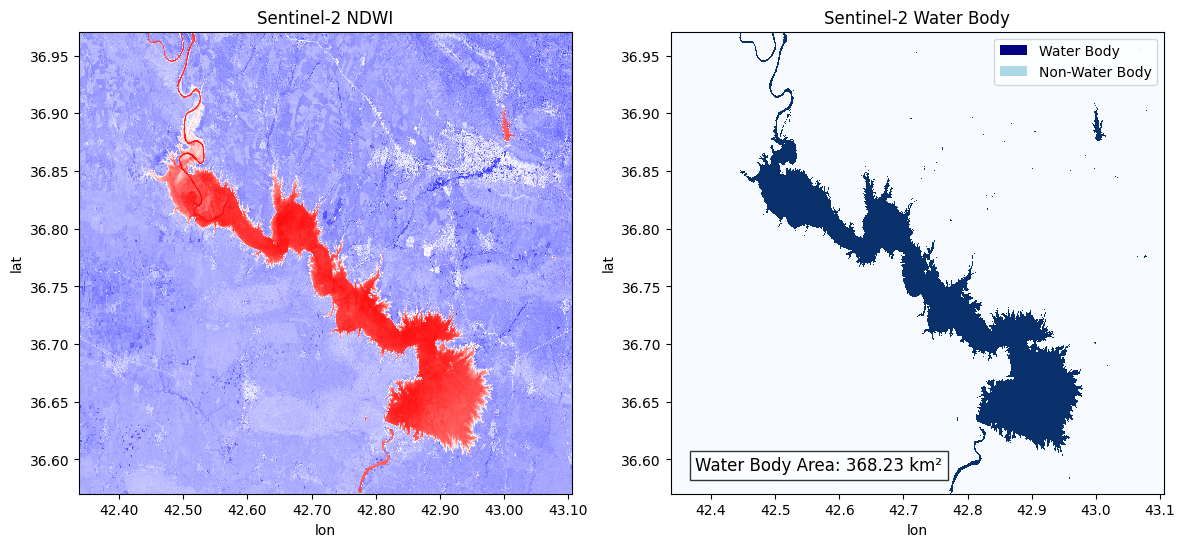

In [ ]:
sentinel = (
    ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
    .filterBounds(roi)
    .filterDate(start_time, end_time)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .select(['B3', 'B8'])
)

def add_year(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    return img.set('year', year)

sentinel_with_year = sentinel.map(add_year)
years = sentinel_with_year.aggregate_array('year').distinct().sort()

def yearly_mean(year):
    year = ee.Number(year)
    filtered = sentinel_with_year.filter(ee.Filter.eq('year', year))
    mean_image = filtered.mean().set('year', year)
    return mean_image

yearly_means = ee.ImageCollection(years.map(yearly_mean))

def sentinel_ndwi(img):
    return img.normalizedDifference(['B3', 'B8']).rename('ndwi').copyProperties(img, img.propertyNames())

ndwi_yearly = yearly_means.map(sentinel_ndwi)

years_list = ndwi_yearly.aggregate_array('year').getInfo()

ds_sentinel = xr.open_dataset(
    ndwi_yearly,
    engine='ee',
    crs='EPSG:4326',
    scale=0.0000898,  # ~10m in degrees
    geometry=roi
)

ds_sentinel['time'] = pd.to_datetime([str(y) for y in years_list]).year
ds_sentinel_mean = ds_sentinel['ndwi'].mean(dim='time')

df_sentinel = ds_sentinel.to_dataframe().reset_index().dropna(subset=['ndwi'])
model_sentinel = KMeans(n_clusters=2, random_state=42)
df_sentinel['clustering'] = model_sentinel.fit_predict(df_sentinel[['ndwi']])
cluster_means_sentinel = df_sentinel.groupby('clustering')['ndwi'].mean()
water_label_sentinel = cluster_means_sentinel.idxmax()
df_sentinel['clustering'] = df_sentinel['clustering'].apply(lambda x: 1 if x == water_label_sentinel else 0)
xarr_sentinel = df_sentinel.set_index(['time', 'lat', 'lon']).to_xarray()
xarr_sentinel = xarr_sentinel.sortby('lon').sortby('lat')

lake_pixels_sentinel = (xarr_sentinel.clustering == 1).sum(dim=['lat', 'lon']).values.item()
lake_area_sentinel = lake_pixels_sentinel * 100 / 1_000_000  # 10m resolution pixel area in km²

ndwi_min_sentinel = ds_sentinel_mean.min().values.item()
ndwi_max_sentinel = ds_sentinel_mean.max().values.item()


fig, axes = plt.subplots(1, 2, figsize=(14,6))  # 1 row, 2 cols

# Fix indexing here:
ds_sentinel_mean.plot(
    ax=axes[0],  # use axes[0] instead of axes[0,0]
    x='lon',
    y='lat',
    cmap='bwr',
    vmin=ndwi_min_sentinel,
    vmax=ndwi_max_sentinel,
    add_colorbar=False
)
axes[0].set_title("Sentinel-2 NDWI")
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

xarr_sentinel.clustering.isel(time=0).plot(
    ax=axes[1],  # use axes[1] instead of axes[0,1]
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=0,
    vmax=1,
    add_colorbar=False
)
axes[1].set_title("Sentinel-2 Water Body")
axes[1].text(
    0.05, 0.05,
    f"Water Body Area: {lake_area_sentinel:.2f} km²",
    transform=axes[1].transAxes,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', alpha=0.8)
)
legend_elements = [
    Patch(facecolor='navy', label='Water Body'),
    Patch(facecolor='lightblue', label='Non-Water Body')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=10)
